In [1]:
'''Trains a simple convnet on the generated set of figures (circle, triangle, square)
'''
from __future__ import print_function


!pip install keras_sequential_ascii

import matplotlib.pyplot as plt
import numpy as np

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Reshape
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation
from keras import backend as K
from keras_sequential_ascii import sequential_model_to_ascii_printout
from keras.utils import plot_model
from keras.utils import np_utils
from keras.optimizers import SGD
from keras.constraints import maxnorm
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras import metrics

from PIL import Image, ImageDraw

import time
import math


  Stored in directory: /root/.cache/pip/wheels/f5/8d/81/912666dff82a923ce423a7e797cd75f54271c7031512cdb282
Successfully built keras-sequential-ascii


Using TensorFlow backend.


In [0]:

batch_size = 128
num_classes = 3
epochs = 64 #12

np.random.seed(2348)

batch_size_gen = 60000
batch_size_val = 10000

# input image dimensions
img_rows, img_cols = 32, 32
img_shape = (img_rows, img_cols)


#probability of noise and the efficiency<1
prob_noise = 0.05



In [0]:
def gen_noise(batch_size_gen=batch_size_gen, img_shape=img_shape, prob_noise=prob_noise):

        batch_events = np.zeros((batch_size_gen, 1, img_shape[0], img_shape[1]))
        for n in range(batch_size_gen):

            for i in range(img_shape[0]):
               for j in range(img_shape[1]):
                 if np.random.random()<prob_noise:
                     batch_events[n,0,i,j]=1


        yield batch_events


In [0]:

### generate geometrical figures

def generate_circle(r, x0, y0, img_shape):
    """
    Generate a single circle.
    Parameters:
        r: radius
        x0,y0: position of the circle center
        img_shape: image shape (depth, width)
    Returns:
        ndarray data for one figure.
    """

    image = Image.new('1', img_shape) #create new image, 10x10 pixels, 1 bit per pixel
    draw = ImageDraw.Draw(image)
    draw.ellipse((x0-r, y0-r, x0+r, y0+r), outline ='white')
    #print(list(image.getdata()))
    #image.show()
    x = np.array(image).astype('int')
    
    #print(x)
    return x

In [0]:
def generate_square(d, x0, y0, angle, img_shape):
    """
    Generate a square.
    Parameters:
        d: size
        x0,y0: position of the square center
        angle: rotation angle
        img_shape: image shape (depth, width)
    Returns:
        ndarray data for one figure.
    """

    image = Image.new('1', img_shape) #create new image, 10x10 pixels, 1 bit per pixel
    draw = ImageDraw.Draw(image)
    draw.rectangle((x0-d/2, y0-d/2, x0+d/2, y0+d/2), outline ='white')
    image = image.rotate(angle)
    #print(list(image.getdata()))
    #image.show()
    x = np.array(image).astype('int')
    
    #print(x)
    return x




In [0]:
def generate_triangle(d, x0, y0, angle, img_shape):
    """
    Generate a square.
    Parameters:
        d: size 
        x0,y0: position of the square center
        angle: rotation angle
        img_shape: image shape (depth, width)
    Returns:
        ndarray data for one figure.
    """

    image = Image.new('1', img_shape) #create new image, 10x10 pixels, 1 bit per pixel
    draw = ImageDraw.Draw(image)
    dd = d/math.sqrt(3)
    draw.polygon(((x0-d/2, y0-dd/2), (x0+d/2, y0-dd/2), (x0,y0+dd)), outline ='white')
    image = image.rotate(angle)
    #print(list(image.getdata()))
    #image.show()
    x = np.array(image).astype('int')
    
    #print(x)
    return x



In [0]:


# generate a random number
def rand_interval(a = 0., b = 1.):
   rnd = a + (b-a)*np.random.random()
   return rnd


In [0]:
# Generator for random figures
# Each image contains exactly one object (circle, triangle, square)
def gen_n_figures(batch_size_gen=batch_size_gen, img_shape=img_shape):

        batch_events  = np.zeros((batch_size_gen, 1, img_shape[0], img_shape[1]))
        batch_targets =-np.ones((batch_size_gen, 1, 1 ))

        for n in range(batch_size_gen):
            
            k = np.random.randint(0,3)
            
            r = rand_interval(img_cols*0.15, img_cols*0.5)
            d = rand_interval(img_cols*0.15, img_cols*0.7) 
            l = rand_interval(img_cols*0.15, img_cols*0.7)
            x0 = rand_interval(0.33*img_cols, 0.66*img_cols)       
            y0 = rand_interval(0.33*img_rows, 0.66*img_rows)     
            alpha = 360.*np.random.random()  

            if k == 0:
               batch_events[n,0] = generate_circle(r, x0, y0, img_shape)
            elif k == 1:
               batch_events[n,0] = generate_square(d, x0, y0, alpha, img_shape)
            elif k == 2:
               batch_events[n,0] = generate_triangle(l, x0, y0, alpha, img_shape)
            else:
               print("Wrong figure id!!!")
            batch_targets[n,0] = k
            


        yield batch_events, batch_targets



In [0]:
#generate training and validation dataset
xx_train, yy_train = gen_n_figures(batch_size_gen, img_shape).next()
xx_test, yy_test   = gen_n_figures(batch_size_val, img_shape).next()
xx_val, yy_val     = gen_n_figures(batch_size_val, img_shape).next()


# add noise
xx_train = xx_train + gen_noise(batch_size_gen, img_shape).next()
xx_test  = xx_test  + gen_noise(batch_size_val, img_shape).next()
xx_val   = xx_val  + gen_noise(batch_size_val, img_shape).next()

#and clip to get maximum 1
xx_train = np.clip(xx_train, 0, 1)
xx_test  = np.clip(xx_test, 0, 1)
xx_val   = np.clip(xx_val, 0, 1)



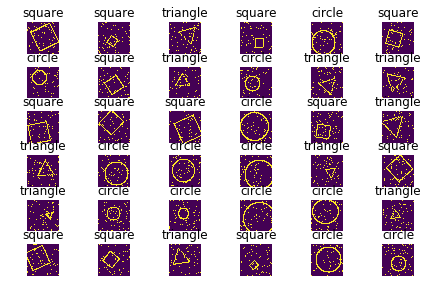

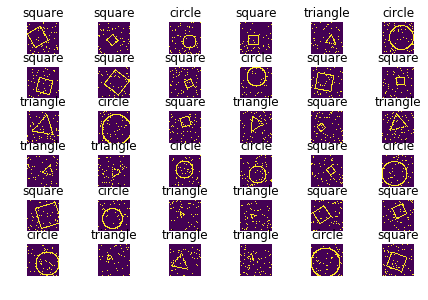

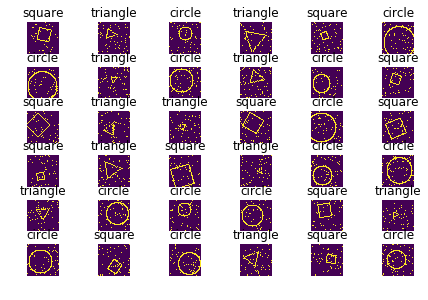

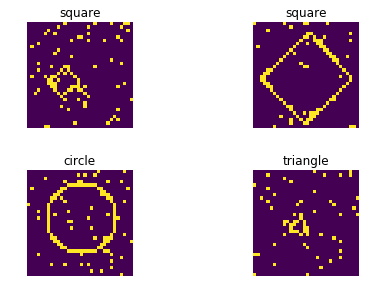

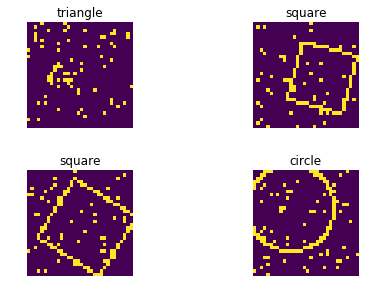

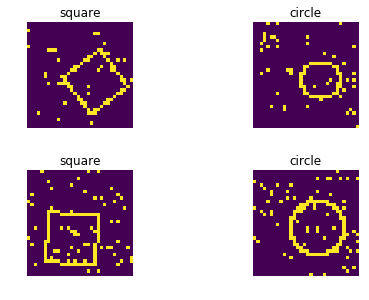

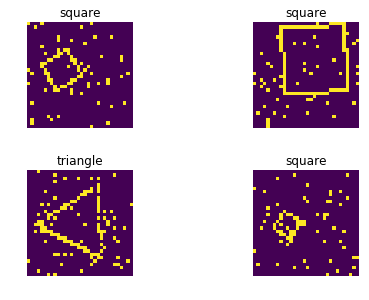

In [10]:

#plot 100 figures (random offset)
class_names = ['circle','square','triangle']


def plot_images(plot_size=6):
  offset = max(0, min(batch_size_gen-plot_size*plot_size, np.random.randint(0,batch_size_gen/2)))
  plt.subplots_adjust(left=0.02, bottom=0.02, right=0.98, top=0.90, wspace=0.20, hspace=0.40)
  for n in range(min(plot_size*plot_size,len(xx_train))):
    ax = plt.subplot(plot_size, plot_size, n+1)
    ax.imshow(xx_train[n+offset,0])
    ax.set_title(class_names[int(yy_train[n+offset,0])])
    ax.axis('off')

  plt.show()
  #plt.savefig('event.png')
  #plt.clf()
  
plot_images(6)
plot_images(6)
plot_images(6)
plot_images(2)
plot_images(2)
plot_images(2)
plot_images(2)

In [11]:
# Convert and pre-processing

yy_train = np_utils.to_categorical(yy_train, num_classes)
yy_test = np_utils.to_categorical(yy_test, num_classes)
yy_val = np_utils.to_categorical(yy_val, num_classes)

print("yy_train ",yy_train.shape)



yy_train  (60000, 1, 3)


In [0]:
# Define Model

def base_model():

    model = Sequential()
    input_shape=(1,img_rows,img_cols)

    model.add(Reshape((img_rows,img_cols,1),input_shape=input_shape))


    model.add(Flatten())
    model.add(Dropout(rate = 0.2))
    model.add(Dense(32*img_rows,activation='relu',kernel_constraint=maxnorm(3))) #1024
    model.add(Dropout(rate = 0.3))
    model.add(Dense(32*img_rows,activation='relu',kernel_constraint=maxnorm(3))) #1024
    model.add(Dropout(rate = 0.3))


    model.add(Dense(num_classes, activation='softmax'))

    model.add(Reshape((1,num_classes),input_shape=(num_classes,)))

#    sgd = SGD(lr = 0.1, decay=1e-6, nesterov=True)
###    sgd = SGD(lr = 0.01, decay=1e-6, nesterov=True)

# Train model

#    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=[metrics.categorical_accuracy])   # 'accuracy'
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[metrics.categorical_accuracy]) 
    return model



In [13]:
# Vizualizing model structure
# Model summary (ascii)
cnn_n = base_model()
cnn_n.summary()

# Model printout (ascii)
sequential_model_to_ascii_printout(cnn_n)

# Plotting model in graphical mode
plot_model(cnn_n)   ###, to_file='model.png')  ###, show_shapes=True



W0714 19:25:24.970063 140367335614336 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0714 19:25:25.003339 140367335614336 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0714 19:25:25.027508 140367335614336 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0714 19:25:25.036844 140367335614336 deprecation.py:506] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a futur

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 32, 32, 1)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)              0         
__________

In [14]:


# patient early stopping
es = EarlyStopping(monitor='val_categorical_accuracy', mode='max', verbose=1, patience=10)
mc = ModelCheckpoint('best_model.h5', monitor='val_categorical_accuracy', mode='max', verbose=1, save_best_only=True)
# fit model
cnn = cnn_n.fit(xx_train, yy_train, batch_size=batch_size, epochs=epochs, validation_data=(xx_test,yy_test),shuffle=True, callbacks=[es, mc])
# load the saved model
saved_model = load_model('best_model.h5')





W0714 19:25:25.495023 140367335614336 deprecation.py:323] From /usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/math_grad.py:1250: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 60000 samples, validate on 10000 samples
Epoch 1/64
60000/60000 [==============================] - 6s 107us/step - loss: 0.8256 - categorical_accuracy: 0.5893 - val_loss: 0.6294 - val_categorical_accuracy: 0.7162

Epoch 00001: val_categorical_accuracy improved from -inf to 0.71620, saving model to best_model.h5
Epoch 2/64
60000/60000 [==============================] - 3s 49us/step - loss: 0.5533 - categorical_accuracy: 0.7458 - val_loss: 0.4742 - val_categorical_accuracy: 0.7951

Epoch 00002: val_categorical_accuracy improved from 0.71620 to 0.79510, saving model to best_model.h5
Epoch 3/64
60000/60000 [==============================] - 3s 49us/step - loss: 0.4141 - categorical_accuracy: 0.8132 - val_loss: 0.4282 - val_categorical_accuracy: 0.8121

Epoch 00003: val_categorical_accuracy improved from 0.79510 to 0.81210, saving model to best_model.h5
Epoch 4/64
60000/60000 [==============================] - 3s 49us/step - loss: 0.3362 - categorical_accuracy: 0.8528 - val_loss: 0

In [15]:

# evaluate loaded model
scores_train = saved_model.evaluate(xx_train, yy_train, verbose=0)
scores_test  = saved_model.evaluate(xx_test,  yy_test,  verbose=0)
scores_val   = saved_model.evaluate(xx_val,   yy_val,   verbose=0)
print("Accuracy Train: %.2f%% , Test: %.2f%% Val: %.2f%% " % (scores_train[1]*100, scores_test[1]*100, scores_val[1]*100))

Accuracy Train: 99.98% , Test: 87.69% Val: 87.74% 


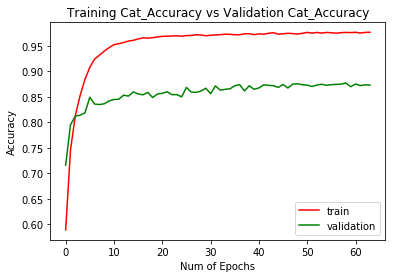

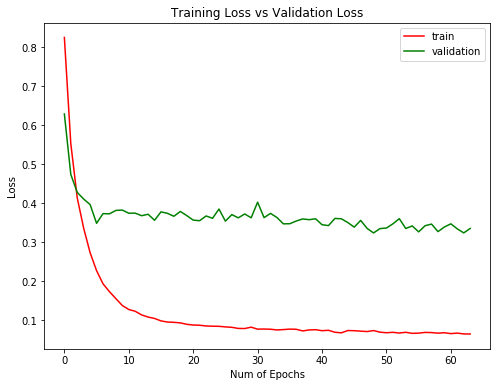

In [16]:


# Plots for training and testing process: loss and accuracy

n_epochs = len(cnn.history['loss'])

plt.figure(0)
plt.plot(cnn.history['categorical_accuracy'],'r')
plt.plot(cnn.history['val_categorical_accuracy'],'g')
plt.xticks(np.arange(0, n_epochs, 10.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Accuracy")
plt.title("Training Cat_Accuracy vs Validation Cat_Accuracy")
plt.legend(['train','validation'])

plt.figure(1)
plt.plot(cnn.history['loss'],'r')
plt.plot(cnn.history['val_loss'],'g')
plt.xticks(np.arange(0, n_epochs, 10.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Validation Loss")
plt.legend(['train','validation'])
plt.show()




[[3218  102    7]
 [ 128 2481  710]
 [   6  273 3075]]


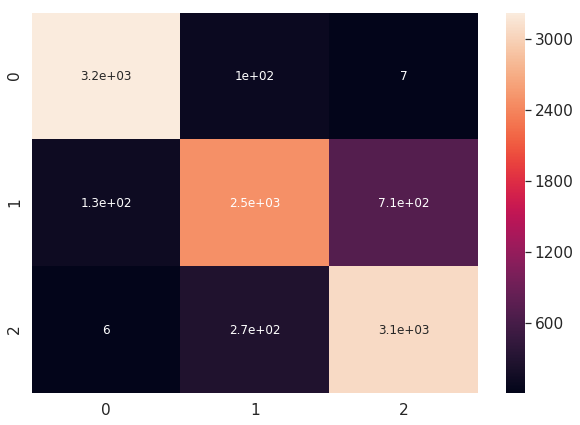

In [17]:
# Confusion matrix result

from sklearn.metrics import classification_report, confusion_matrix
YY_pred = saved_model.predict(xx_val, verbose=2)
yy_pred = np.argmax(YY_pred, axis=2)

yy_test2 = np.argmax(yy_test, axis=2)



#confusion matrix
cm = confusion_matrix(np.argmax(yy_val,axis=2),yy_pred)
print(cm)

# Visualizing of confusion matrix
import seaborn as sn
import pandas  as pd


df_cm = pd.DataFrame(cm, range(num_classes),
                  range(num_classes))
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 12})# font size
plt.show()


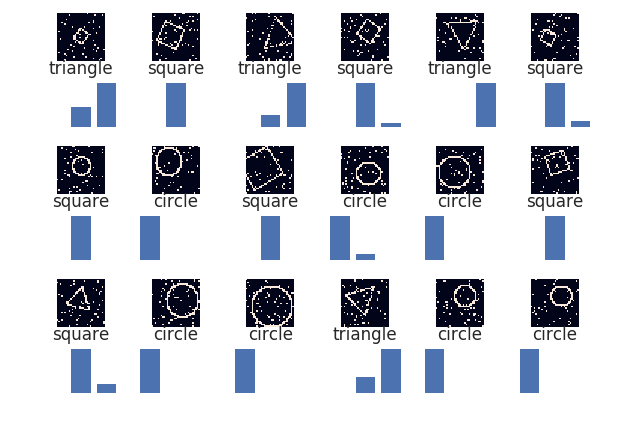

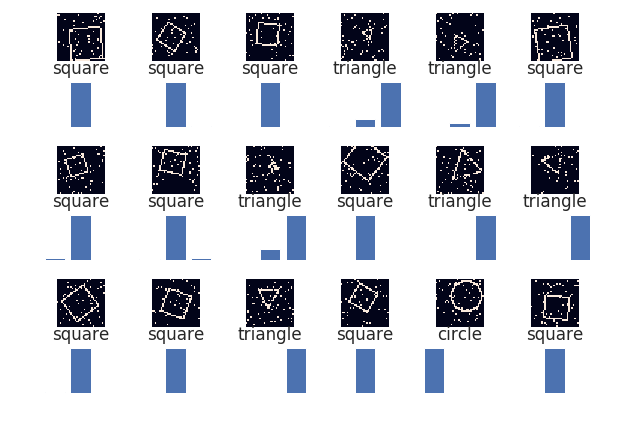

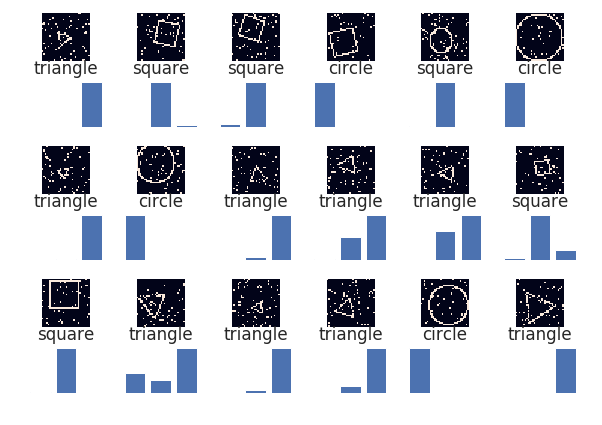

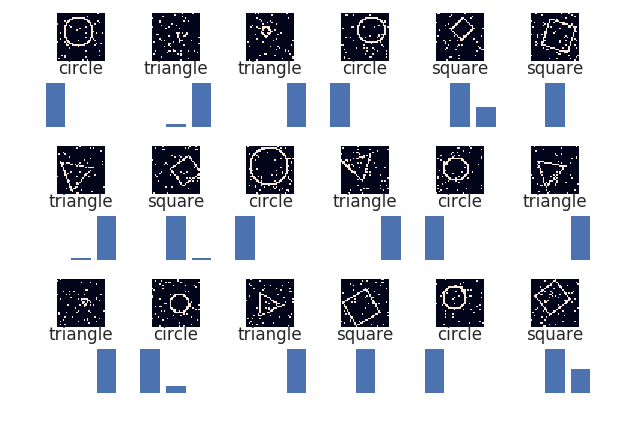

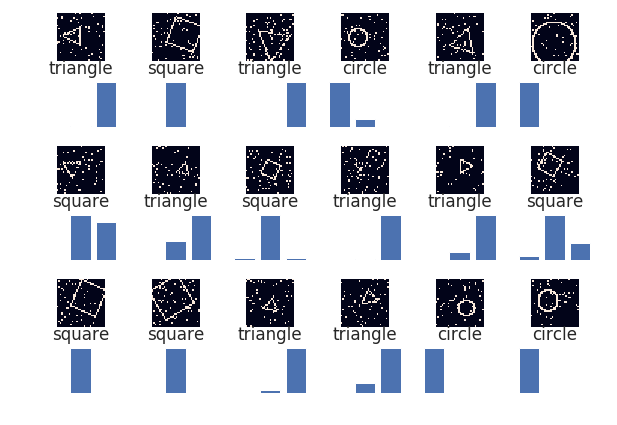

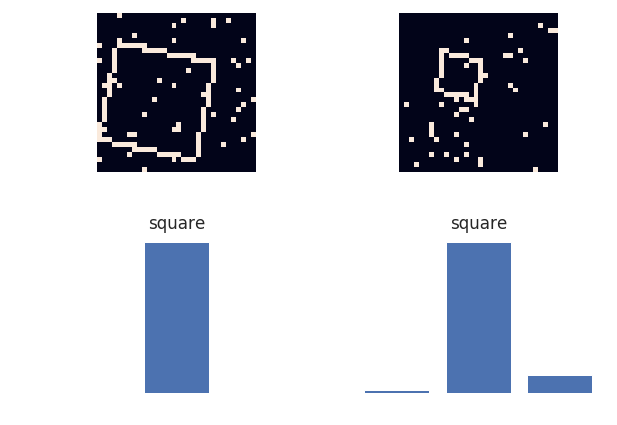

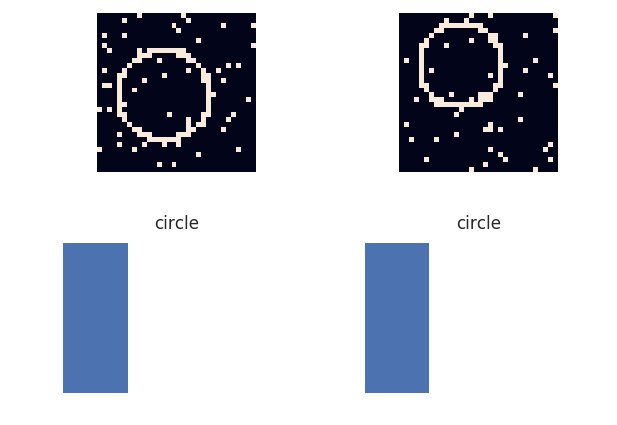

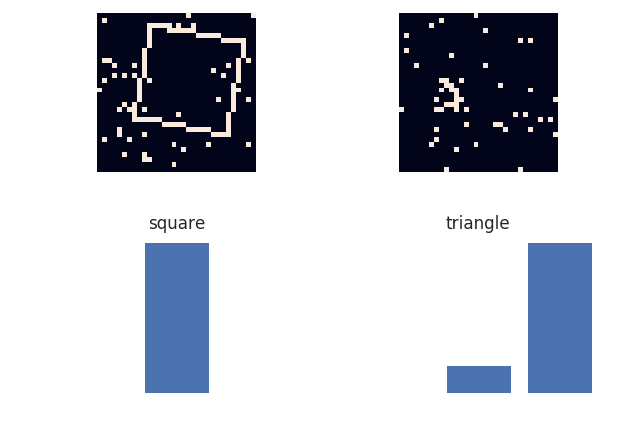

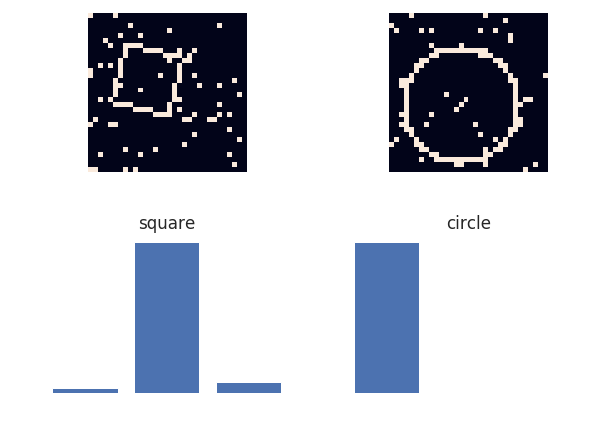

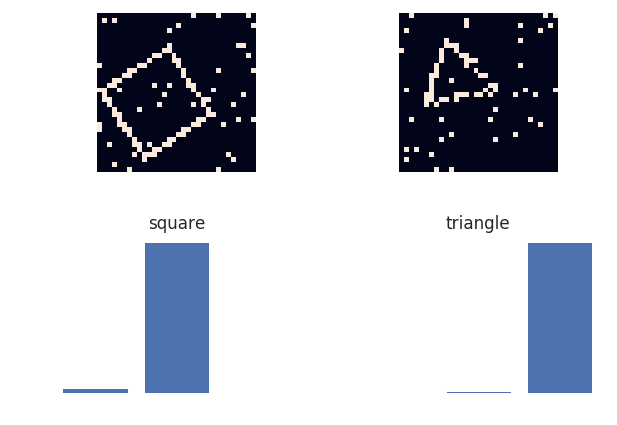

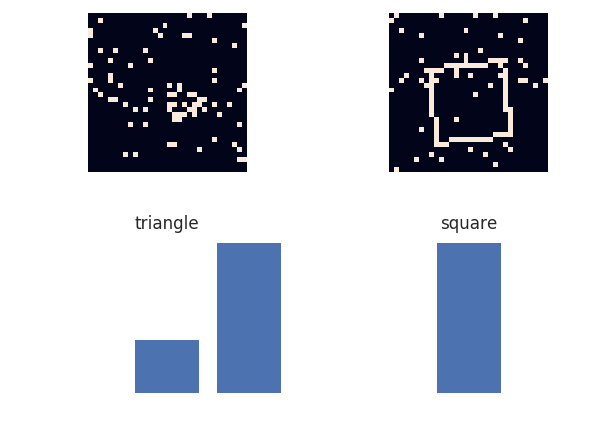

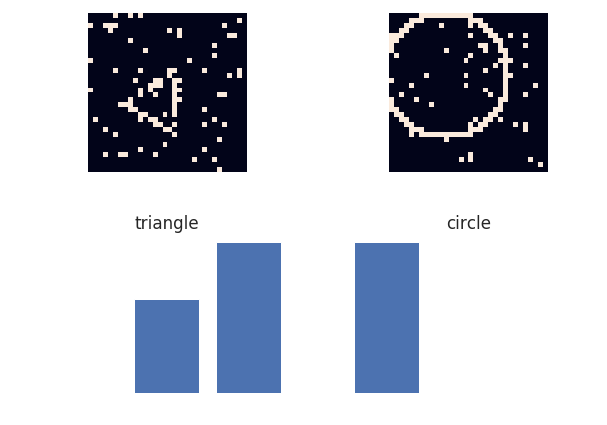

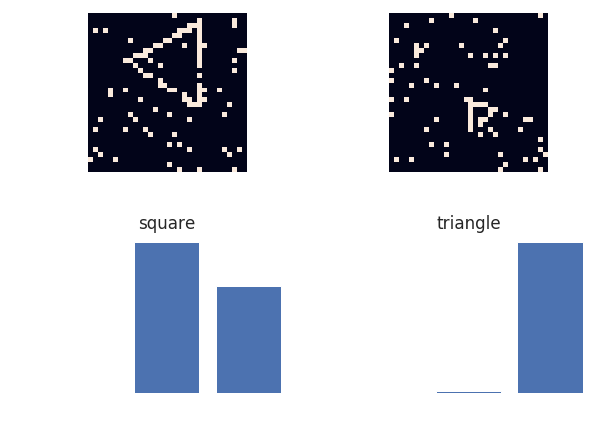

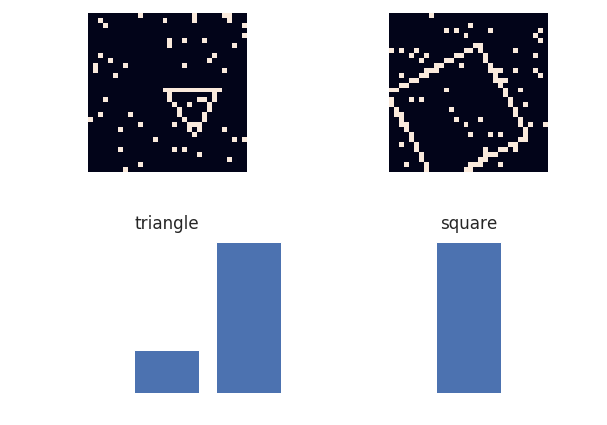

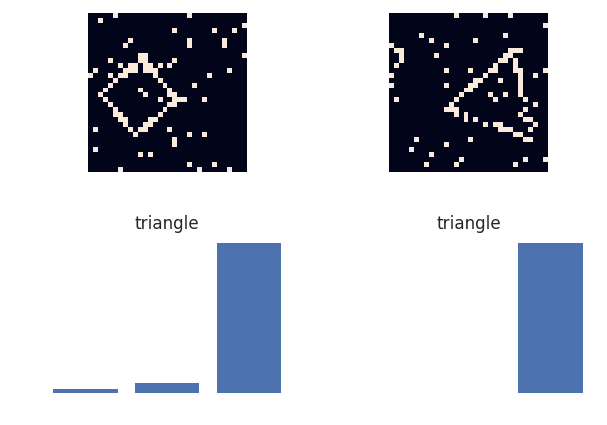

In [18]:

def plot_results(plot_size=6):
  
  offset = max(0, min(len(YY_pred)-plot_size*plot_size, np.random.randint(0,len(YY_pred)/2)))

  plt.subplots_adjust(left=0.02, bottom=0.02, right=0.98, top=0.90, wspace=0.20, hspace=0.40)
  for i in range(min(plot_size/2,len(YY_pred)/plot_size)):
    for n in range(min(plot_size,len(YY_pred))):
      ax = plt.subplot(plot_size,plot_size,plot_size*2*i+n+1 )
      ax.imshow(xx_val[plot_size*i+n+offset,0])
      ax.axis('off')

    for n in range(min(plot_size,len(YY_pred))):
      ax = plt.subplot(plot_size,plot_size,plot_size*2*i+plot_size+n+1)
      x = np.arange(3)
      ax.bar(x, height = YY_pred[plot_size*i+n+offset,0], tick_label = class_names) 
      ax.axis('off')
      ax.set_title(class_names[int(np.argmax(YY_pred,axis=2)[plot_size*i+n+offset])])

  
  
  plt.show()
  #plt.savefig('event.png')
  #plt.clf()


plot_results(6)
plot_results(6)
plot_results(6)
plot_results(6)
plot_results(6)

plot_results(2)
plot_results(2)
plot_results(2)
plot_results(2)
plot_results(2)
plot_results(2)
plot_results(2)
plot_results(2)
plot_results(2)
plot_results(2)


